In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('data/train.csv',dtype={'Age':np.float64})
test = pd.read_csv('data/test.csv',dtype={'Age':np.float64})
PassengerId = test['PassengerId']
all_data = pd.concat([train,test],ignore_index=True)

Percentage of females who survived:74.20
Percentage of males who survived:18.89


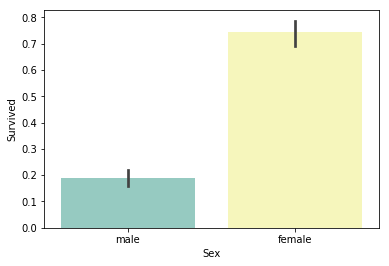

In [2]:
# 1、数据可视化
# 1)Sex Feature: 女性幸存率远高于男性
sns.barplot(x='Sex',y='Survived',data=train,palette='Set3')
print('Percentage of females who survived:%.2f' % (train['Survived'][train['Sex'] == 'female'].value_counts(normalize=True)[1]*100))
print('Percentage of males who survived:%.2f'% (train['Survived'][train['Sex']=='male'].value_counts(normalize=True)[1]*100))

Percentage of Pclass =1 who survived:62.96
Percentage of Pclass =2 who survived:47.28
Percentage of Pclass =3 who survived:24.24


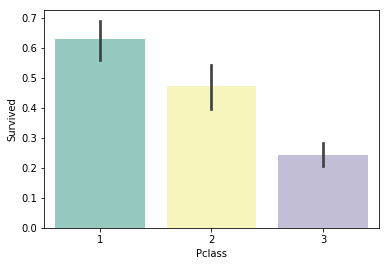

In [3]:
# 2)Pclass Feature:乘客社会等级越高，幸存率越高
sns.barplot(x='Pclass',y='Survived',data=train,palette='Set3')
print('Percentage of Pclass =1 who survived:%.2f' % (train['Survived'][train['Pclass']==1].value_counts(normalize=True)[1]*100))
print('Percentage of Pclass =2 who survived:%.2f' % (train['Survived'][train['Pclass']==2].value_counts(normalize=True)[1]*100))
print('Percentage of Pclass =3 who survived:%.2f' % (train['Survived'][train['Pclass']==3].value_counts(normalize=True)[1]*100))


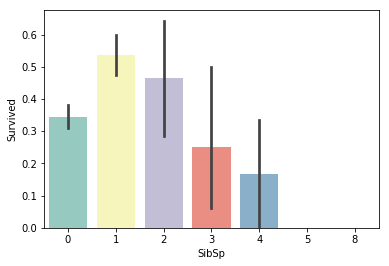

In [4]:
# 3)SibSp Feature: 配偶及兄弟姐妹数适中的乘客幸存率更高
sns.barplot(x='SibSp',y='Survived',data=train,palette='Set3')

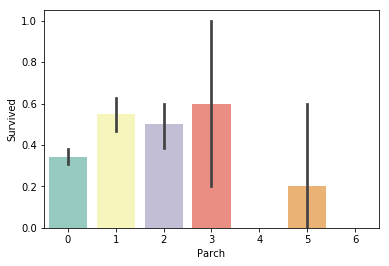

In [5]:
# 4)Parch Feature:父母与子女数适中的乘客幸存率更高
sns.barplot(x='Parch',y='Survived',data=train,palette='Set3')

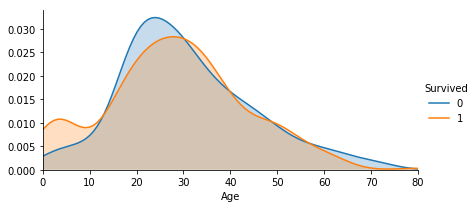

In [6]:
# 5)Age Feature:未成年人幸存率高于成年人

facet = sns.FacetGrid(train,hue='Survived',aspect=2)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0,train['Age'].max()))
facet.add_legend()

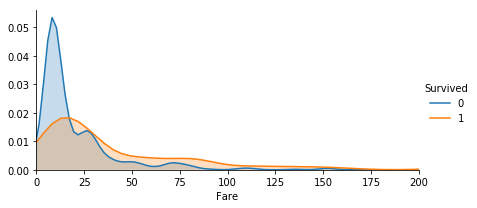

In [7]:
# 6)Fare Feature:支出船票费越高幸存率越高
facet = sns.FacetGrid(train,hue='Survived',aspect=2)
facet.map(sns.kdeplot,'Fare',shade=True)
facet.set(xlim=(0,200))
facet.add_legend()

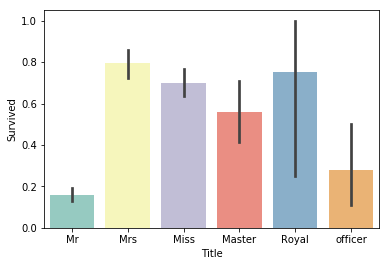

In [8]:
# 7)Title Feature(New):不同称呼的乘客幸存率不同
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt','Col','Major','Dr','Rev'],'officer'))
Title_Dict.update(dict.fromkeys(['Don','Sir','the Countess','Dona','Lady'],'Royal'))
Title_Dict.update(dict.fromkeys(['Mme','Ms','Mrs'],'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle','Miss'],'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'],'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'],'Master'))
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x='Title',y='Survived',data=all_data,palette='Set3')

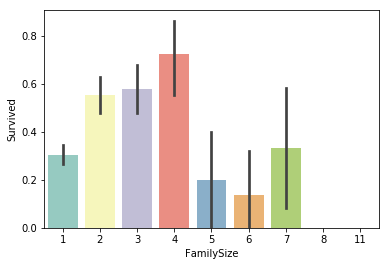

In [9]:
# 8)FamilyLabel Feature(New):家庭人数为2到4的乘客幸存率较高
#FamilySize = Parch + SibSp + 1
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
sns.barplot(x='FamilySize',y='Survived',data=all_data,palette='Set3')

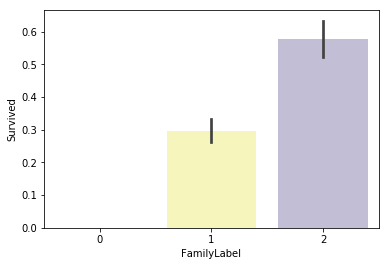

In [10]:
# 按照生存率把FamilySize分为三类，构成FamilyLabel特征
def Fam_label(s):
    if (s>=2) & (s<=4):
        return 2
    elif ((s>4) & (s<=7)) | (s==1):
        return 1
    elif s>7:
        return 0

all_data['FamilyLabel'] = all_data['FamilySize'].apply(Fam_label)
sns.barplot(x='FamilyLabel',y='Survived',data=all_data,palette='Set3')

In [11]:
# 10)TicketGroup Feature(New):与2至4人共票号的乘客幸存率较高
# 新增TicketGroup特征，统计每个乘客的共票号数
Ticket_Count = dict(all_data['Ticket'].value_counts())

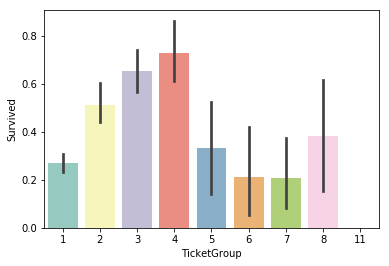

In [12]:
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x: Ticket_Count[x])
sns.barplot(x='TicketGroup',y='Survived',data=all_data,palette='Set3')

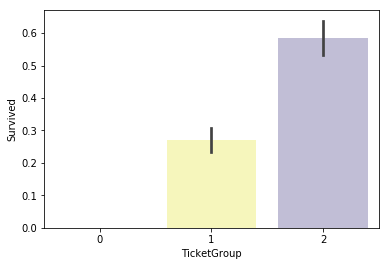

In [13]:
# 按照生存率把TicketGroup分为三类：
def Ticket_Label(s):
    if (s>=2) & (s<=4):
        return 2
    elif ((s>4) & (s<=8)) | (s==1):
        return 1
    elif (s>8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup',y='Survived',data=all_data,palette='Set3')

In [14]:
# 2、数据清洗
# 1）缺失值填充：
# Age Feature:Age缺失量为263，确实量较大，用Sex,Title,Pclass三个特征构建随机森林模型，填充年龄缺失值
age_df = all_data[['Age','Pclass','Sex','Title']]
age_df = pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values
y=known_age[:,0]
X=known_age[:,1:]
rfr = RandomForestRegressor(random_state=0,n_estimators=100,n_jobs=-1)
rfr.fit(X,y)
predictedAges = rfr.predict(unknown_age[:,1:])
all_data.loc[ (all_data.Age.isnull()),'Age']=predictedAges

In [15]:
# Embarked Feature: 缺失量为2，缺失信息的乘客的Pclass均为1，且Fare均为80，
# 因为Embarked为C且Pclass为1的乘客的Fare的中位数为80，故而将缺失值填充为C
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,2


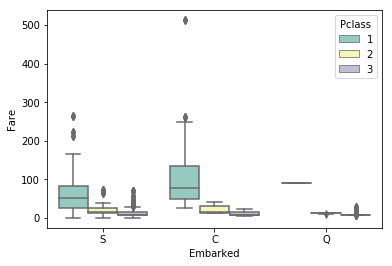

In [16]:
sns.boxplot(x='Embarked',y='Fare',hue='Pclass',data=all_data,palette='Set3')

In [17]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [18]:
# Fare Feature:缺失量为1，缺失Fare信息的乘客的Embarked为S，Pclass为3，
# 所以用Embarked为S，Pclass为3的乘客的Fare中位数填充
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,TicketGroup
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,1


In [19]:
fare=all_data[(all_data['Embarked'] == 'S') & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare'] = all_data['Fare'].fillna(fare)

In [21]:
# 2)同组识别
# 把姓氏相同的乘客划分为一组，从人数大于1的组中分别提取出每组的妇女儿童和成年男性
all_data['Surname'] = all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group = all_data.loc[(all_data['FamilyGroup'] >= 2) & ((all_data['Age'] <= 12) | (all_data['Sex'] == 'female'))]
Male_Adult_Group = all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age'] > 12) & (all_data['Sex']=='male')]


In [22]:
Female_Child = pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child
# 发现绝大部分女性和儿童的平均存活率都为1或者0，即同组的女性和儿童要么全部幸存，要么全部遇难

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5,0,'AverageSurvived')

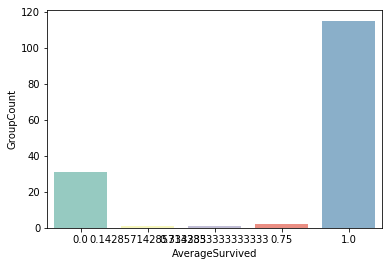

In [23]:
sns.barplot(x=Female_Child.index,y=Female_Child['GroupCount'],palette='Set3').set_xlabel('AverageSurvived')

In [24]:
Male_Adult = pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult
# 绝大部分成年男性组的平均存活率也为1或者0

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


In [34]:
# 因为普遍规律是女性和儿童幸存率高，成年男性幸存较低，所以把不符合普遍规律的反常组选出来单独处理。
# 把女性和儿童组中幸存率为0的组设置为遇难组，把成年男性组中存活率为1的设置为幸存组
Female_Child_List = Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List = set(Female_Child_List[Female_Child_List.apply(lambda x: x==0)].index)
print(Dead_List)

Male_Adult_List = Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List = set(Male_Adult_List[Male_Adult_List.apply(lambda x: x==1)].index)
print(Survived_List)

{'Johnston', 'Attalah', 'Ilmakangas', 'Olsson', 'Lahtinen', 'Goodwin', 'Sage', 'Boulos', 'Jussila', 'Palsson', 'Lefebre', 'Skoog', 'Ford', 'Turpin', 'Bourke', 'Danbom', 'Caram', 'Zabour', 'Vander Planke', 'Robins', 'Cacic', 'Rosblom', 'Barbara', 'Rice', 'Panula', 'Oreskovic', 'Van Impe', 'Lobb', 'Canavan', 'Arnold-Franchi', 'Strom'}
{'Taylor', 'Kimball', 'Jonsson', 'Chambers', 'Jussila', 'Frauenthal', 'McCoy', 'Harder', 'Nakid', 'Frolicher-Stehli', 'Beane', 'Greenfield', 'Bishop', 'Beckwith', 'Bradley', 'Duff Gordon', 'Dick', 'Cardeza', 'Goldenberg', 'Daly'}


In [35]:
# 为了使处于这两种反常组的样本能够被正确分类，对测试集中处于反常组中的样本的Age,Title,Sex
train = all_data.loc[all_data['Survived'].notnull()]
test = all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

In [39]:
# 3)特征转化
all_data = pd.concat([train,test])
all_data = all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','TicketGroup']]
all_data = pd.get_dummies(all_data)
train = all_data[all_data['Survived'].notnull()]
test = all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.values[:,1:]
y = train.values[:,0]

In [53]:
# 3.建模和优化
# 1)参数优化
pipe = Pipeline([('select',SelectKBest(k=15)),
                ('classify',RandomForestClassifier(random_state=10,max_features='sqrt'))])
param_test = {'classify__n_estimators':list(range(20,50,2)),
             'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe,param_grid = param_test,scoring='roc_auc',cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_,gsearch.best_score_)

{'classify__max_depth': 6, 'classify__n_estimators': 20} 0.8771219521830205


In [54]:
# 2)训练模型
select = SelectKBest(k=15)
clf = RandomForestClassifier(random_state=10,warm_start=True,n_estimators=20,max_depth=6,max_features='sqrt')
pipeline = make_pipeline(select,clf)
pipeline.fit(X,y)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=15, score_func=<function f_classif at 0x0000028D42F41400>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decreas...imators=20, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

In [56]:
# 3)交叉验证
cv_score = cross_val_score(pipeline,X,y,cv=10)
print('CV Score: Mean - %.7g | Std - %.7g' % (np.mean(cv_score),np.std(cv_score)))

CV Score: Mean - 0.8349895 | Std - 0.03663602


In [58]:
# 4.预测
predictions = pipeline.predict(test)
submission = pd.DataFrame({'PassengerId':PassengerId,'Survived':predictions.astype(np.int32)})
submission.to_csv('output/submission1222.csv',index=False)